In [ ]:
# --- Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from ucimlrepo import fetch_ucirepo

In [ ]:
# --- 1. Fetch dataset ---
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np

dataset = fetch_ucirepo(id=235)
X = dataset.data.features
y = dataset.data.targets
df = pd.concat([X, y], axis=1)

/usr/local/lib/python3.12/dist-packages/ucimlrepo/fetch.py:97: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_url)


In [ ]:
# --- 2. Combine Date + Time into datetime ---
df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], dayfirst=True, errors='coerce')
df.set_index('datetime', inplace=True)

# --- 3. Keep only numeric cols ---
numeric_cols = ['Global_active_power','Global_reactive_power','Voltage',
                'Global_intensity','Sub_metering_1','Sub_metering_2','Sub_metering_3']

# Force numeric conversion
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# --- 4. Handle missing values ---
df = df.ffill()   # future-proof replacement for fillna(method='ffill')

# --- 5. Resample hourly ---
df_hourly = df[numeric_cols].resample('h').mean()  # lowercase 'h' instead of 'H'

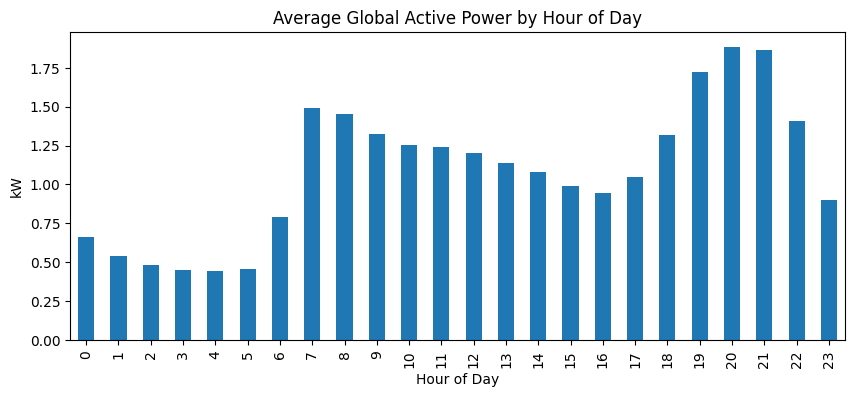

In [ ]:
# --- 5b. Feature Engineering: Lag & Rolling Features ---

# Lags of Global Active Power (previous 1, 2, 3 hours)
df_hourly['lag1'] = df_hourly['Global_active_power'].shift(1)
df_hourly['lag2'] = df_hourly['Global_active_power'].shift(2)
df_hourly['lag3'] = df_hourly['Global_active_power'].shift(3)

# Rolling window features (3-hour and 6-hour moving averages)
df_hourly['roll3_mean'] = df_hourly['Global_active_power'].rolling(window=3).mean()
df_hourly['roll6_mean'] = df_hourly['Global_active_power'].rolling(window=6).mean()

# Drop NA rows caused by lag/rolling
df_hourly = df_hourly.dropna()

# --- 5c. Feature Engineering: Time-based Features ---
df_hourly['hour'] = df_hourly.index.hour
df_hourly['dayofweek'] = df_hourly.index.dayofweek  # 0=Monday
df_hourly['is_weekend'] = df_hourly['dayofweek'].isin([5,6]).astype(int)

# Optional visualization
plt.figure(figsize=(10,4))
df_hourly.groupby('hour')['Global_active_power'].mean().plot(kind='bar')
plt.title("Average Global Active Power by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("kW")
plt.show()


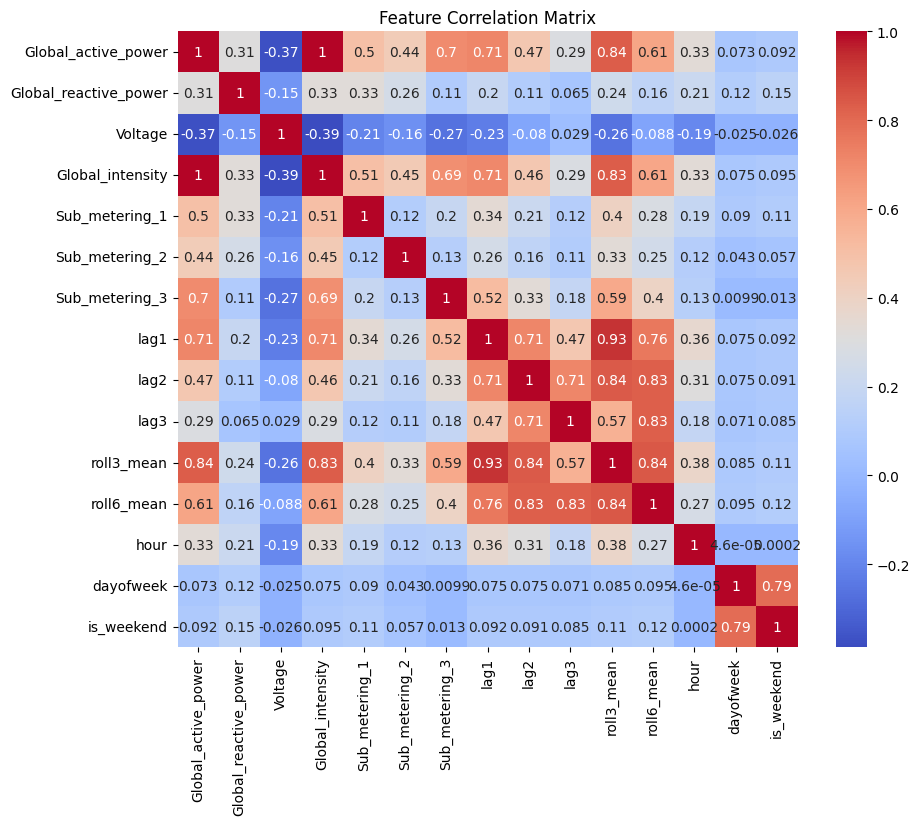

In [ ]:
# --- 3. Feature importance ---
corr_matrix = df_hourly.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

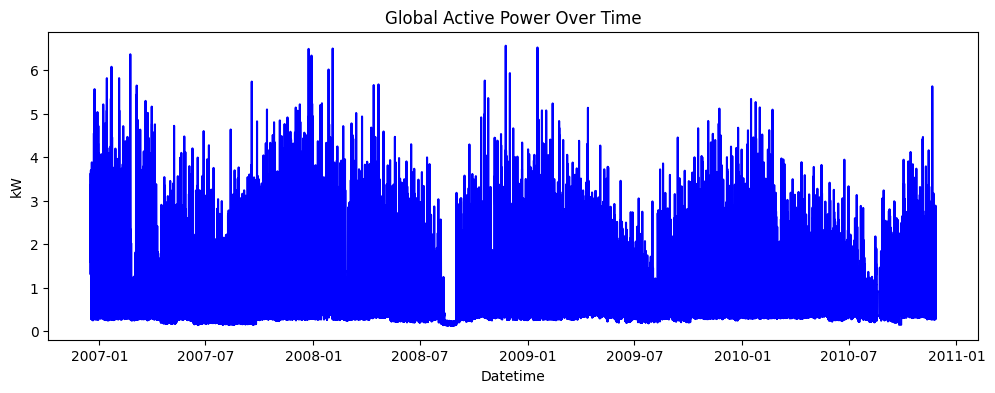

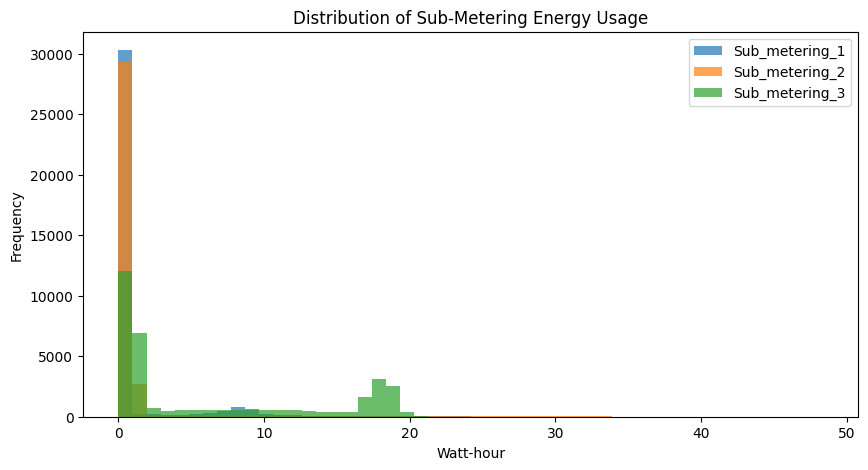

In [ ]:
# --- 4. Data visualization ---
plt.figure(figsize=(12,4))
plt.plot(df_hourly.index, df_hourly['Global_active_power'], color='blue')
plt.title('Global Active Power Over Time')
plt.xlabel('Datetime')
plt.ylabel('kW')
plt.show()

df_hourly[['Sub_metering_1','Sub_metering_2','Sub_metering_3']].plot(
    kind='hist', bins=50, figsize=(10,5), alpha=0.7
)
plt.title('Distribution of Sub-Metering Energy Usage')
plt.xlabel('Watt-hour')
plt.show()

In [ ]:
# --- 5. Scale data ---
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_hourly)


In [ ]:
# --- 6. Create sequences for LSTM ---
SEQ_LENGTH = 24  # past 24 hours to predict next hour
def create_sequences(data, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(data)-seq_length):
        X_seq.append(data[i:i+seq_length])
        y_seq.append(data[i+seq_length, 0])  # predicting Global_active_power
    return np.array(X_seq), np.array(y_seq)

X_seq, y_seq = create_sequences(scaled_data, SEQ_LENGTH)

In [ ]:
# --- 7. Train-test split ---
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)

In [ ]:
# --- 8. Build and train LSTM model ---
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(SEQ_LENGTH, X_seq.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


864/864 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.0144 - val_loss: 0.0063
Epoch 2/20
864/864 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0086 - val_loss: 0.0060
Epoch 3/20
864/864 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.0079 - val_loss: 0.0057
Epoch 4/20
864/864 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 0.0075 - val_loss: 0.0055
Epoch 5/20
864/864 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.0073 - val_loss: 0.0055
Epoch 6/20
864/864 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0072 - val_loss: 0.0055
Epoch 7/20
864/864 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0070 - val_loss: 0.0054
Epoch 8/20
864/864 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.0070 - val_loss: 0.0052
Epoch 9/20
864/864 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.0070 - val_loss: 0.0053
Epoch 10/20
864/864 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.0070 - val_loss: 0.0053
Epoch 11/20
864/864 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0068 - val_loss: 0.0055
Epoch 12/20
864/864 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss

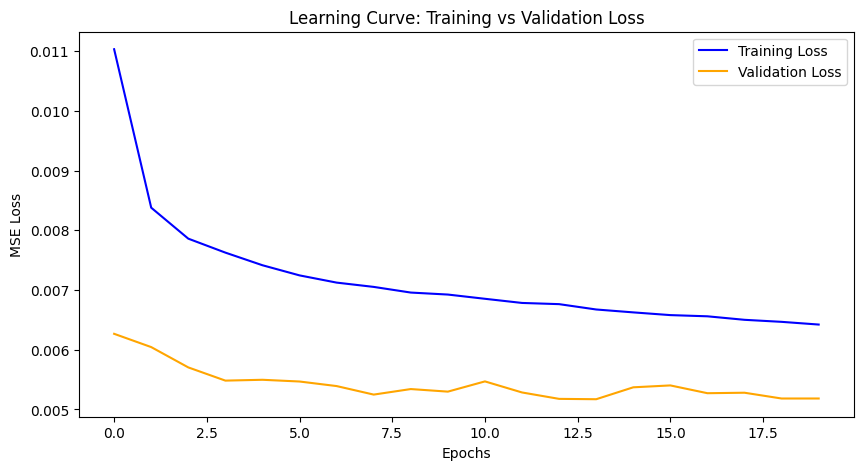

In [ ]:
# --- 13. Plot training vs validation loss (learning curve) ---
history = model.history.history

plt.figure(figsize=(10,5))
plt.plot(history['loss'], label='Training Loss', color='blue')
plt.plot(history['val_loss'], label='Validation Loss', color='orange')
plt.title("Learning Curve: Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()


In [ ]:
# --- 9. Predictions ---
y_pred = model.predict(X_test)
y_pred_rescaled = scaler.inverse_transform(
    np.concatenate([y_pred, np.zeros((y_pred.shape[0], scaled_data.shape[1]-1))], axis=1)
)[:,0]

216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [ ]:
# --- 10. Rescale y_test for comparison ---
y_test_rescaled = scaler.inverse_transform(
    np.concatenate([y_test.reshape(-1,1), np.zeros((y_test.shape[0], scaled_data.shape[1]-1))], axis=1)
)[:,0]


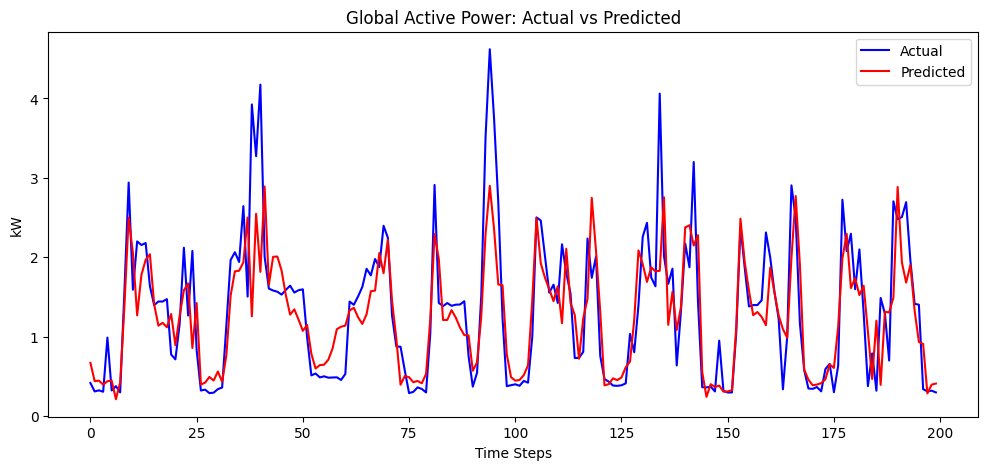

In [ ]:
# --- 11. Plot predictions vs actual ---
plt.figure(figsize=(12,5))
plt.plot(y_test_rescaled[:200], label="Actual", color="blue")
plt.plot(y_pred_rescaled[:200], label="Predicted", color="red")
plt.title("Global Active Power: Actual vs Predicted")
plt.xlabel("Time Steps")
plt.ylabel("kW")
plt.legend()
plt.show()

In [ ]:
# --- 12. Performance metrics ---
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
r2 = r2_score(y_test_rescaled, y_pred_rescaled)

In [ ]:
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R² Score: {r2:.4f}")

RMSE: 0.4634
MAE: 0.3240
R² Score: 0.5979
